# **The Problem: Automatic Apparent Age Estimation**



# Auxiliary and introductory material

Getting Started with TensorFlow in Google Colaboratory
Intro to Google Colab:
https://www.youtube.com/watch?v=inN8seMm7UI

Installing Tensorflow (CPU or GPU):
https://www.youtube.com/watch?v=PitcORQSjNM

# Pre-requisites:
Installing tensorflow-gpu (GPU) and OpenCv.
Check GPU usage instructions [here](https://research.google.com/colaboratory/faq.html#gpu-availability)

In [ ]:
!pip install tensorflow
#!pip install tensorflow-gpu
!pip install opencv-python
!pip install h5py

# to enable Colab-GPU version:
# 1) Runtime -> reset runtime
# 2) Runtime -> Change runtime type

# Downloading and decompressing the Appa-Real Age Dataset [(source)](http://chalearnlap.cvc.uab.es/challenge/13/track/13/description/)

- As default, RGB images (cropped faces) are in the range of [0, 255], and labels are in the range of ~0.9 to ~90 (years old).
- The data is divided in train, validation and test set. 
- Matadata is also provided
  - gender: male / female 
  - ethnicity: asian / afroamerican / caucasian
  - facial expression: neutral / slightlyhappy / happy / other


In [ ]:
# downloading the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip

# decompressing the data
from zipfile import ZipFile

with ZipFile('app_data.zip','r') as zip:
   zip.extractall()
   print('Data decompressed successfully')

# removing the .zip file after extraction to clean space
!rm app_data.zip

--2021-09-20 16:09:58--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799021037 (762M) [application/zip]
Saving to: ‘app_data.zip’

app_data.zip        100%[===================>] 762.00M  9.43MB/s    in 70s     

2021-09-20 16:11:09 (10.9 MB/s) - ‘app_data.zip’ saved [799021037/799021037]

Data decompressed successfully


# Loading the train/validation data, and re-scaling the labels to [0..1]
- X_[train,valid,test] = Face images
- Y_[train,valid,test] = Ground truth 
- M_[train,valid,test] = Metadata (gender, ethnicicy, facial expression)

In [ ]:
import numpy as np

# loading the train data
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
M_train = np.load('./data/meta_data_train.npy')

# loading the validation data
X_valid = np.load('./data/data_valid.npy')
Y_valid = np.load('./data/labels_valid.npy')
M_valid = np.load('./data/meta_data_valid.npy')

# loading the test data
X_test = np.load('./data/data_test.npy')
Y_test = np.load('./data/labels_test.npy')
M_test = np.load('./data/meta_data_test.npy')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train = Y_train/100
Y_valid = Y_valid/100
# Y_test = Y_test/100 # -> we don't normalize the test labels as we will evaluate 
                      # them using the raw data, i.e., the apparent age values

print('Train data size and shape', X_train.shape)
print('Train labels size and shape', Y_train.shape)
print('Train metadata size and shape', M_train.shape)
print('----')
print('Valid data size and shape', X_valid.shape)
print('Valid labels size and shape', Y_valid.shape)
print('Valid metadata size and shape', M_valid.shape)
print('----')
print('Test data size and shape', X_test.shape)
print('Test labels size and shape', Y_test.shape)
print('Test metadata size and shape', M_test.shape)

Train data size and shape (4065, 224, 224, 3)
Train labels size and shape (4065,)
Train metadata size and shape (4065, 3)
----
Valid data size and shape (1482, 224, 224, 3)
Valid labels size and shape (1482,)
Valid metadata size and shape (1482, 3)
----
Test data size and shape (1978, 224, 224, 3)
Test labels size and shape (1978,)
Test metadata size and shape (1978, 3)


# Visualizing some training samples
Next, we multiply the normalized age labels by 100 to show the original age values on top of each sample.

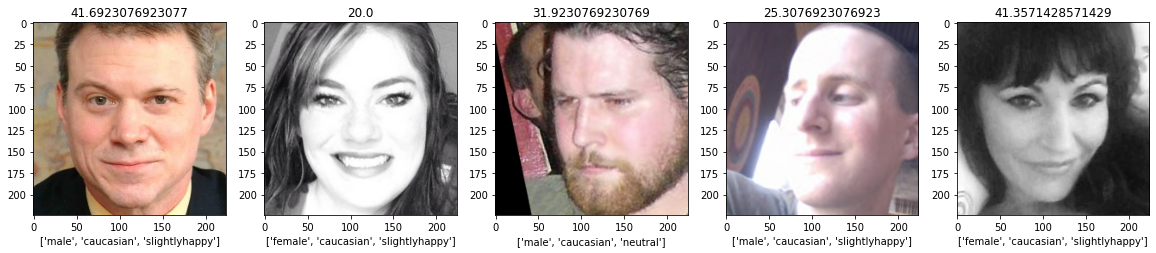

In [ ]:
import cv2
import random
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes):
    idx = random.randint(0, len(X_train))
    ax.imshow(cv2.cvtColor(X_train[idx,:,:,:], cv2.COLOR_BGR2RGB))
    ax.set_title(Y_train[idx]*100)
    ax.set(xlabel=[M_train[idx][0],M_train[idx][1],M_train[idx][2]])



# Visualizing the age distribution of Train data

(0.0, 100.0)

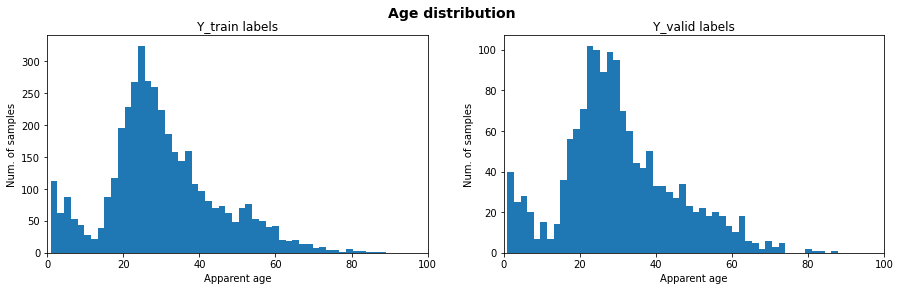

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_valid*100, bins = 50)
ax2.set_title('Y_valid labels')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])

# Visualizing the distributions of metadata (Train data)

(array([1404.,    0.,    0., 1784.,    0.,    0.,  712.,    0.,    0.,
         165.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

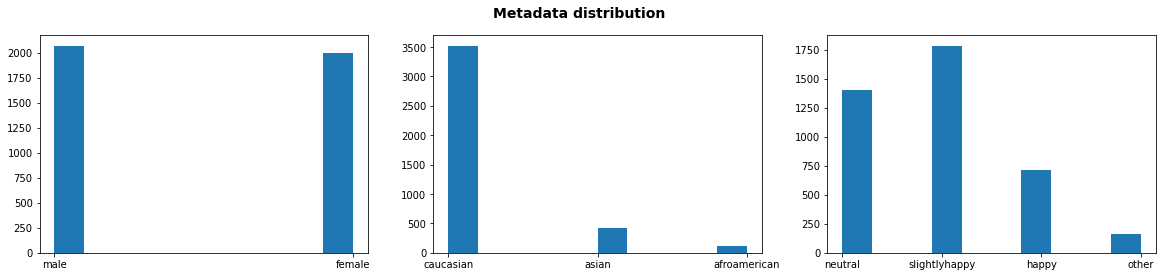

In [ ]:
gender = []
etnhicity = []
emotion = []
for sample in M_train:
  gender.append(sample[0])
  etnhicity.append(sample[1])
  emotion.append(sample[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')

ax1.hist(gender)
ax2.hist(etnhicity)
ax3.hist(emotion)

# Visualizing the age distribution per Ethnicity
- First, we define a function to visualize the age distribution per ethnicity. Then, we visualize the distributions of train / validation / test sets.

In [ ]:
def compute_hist_per_ethnicity(y_data, metadata, set):
  
  vec_as = []
  vec_af = []
  vec_ca = []
  for i in range(0,len(y_data)):
    if(metadata[i][1] == 'asian'):
      vec_as.append(y_data[i])
    if(metadata[i][1] == 'afroamerican'):
      vec_af.append(y_data[i])
    if(metadata[i][1] == 'caucasian'):
      vec_ca.append(y_data[i])

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
  fig.suptitle(['Age distribution per Ethnicity ', set], fontsize=14, fontweight='bold')

  ax1.hist(vec_as, bins=50)
  ax1.set_xlim([0, 100])
  ax1.set(xlabel='Asian', ylabel='Num. of samples')

  ax2.hist(vec_af, bins=50)
  ax2.set_xlim([0, 100])
  ax2.set(xlabel='Afroamerican', ylabel='Num. of samples')

  ax3.hist(vec_ca, bins=50) 
  ax3.set_xlim([0, 100])
  ax3.set(xlabel='Caucasian', ylabel='Num. of samples')


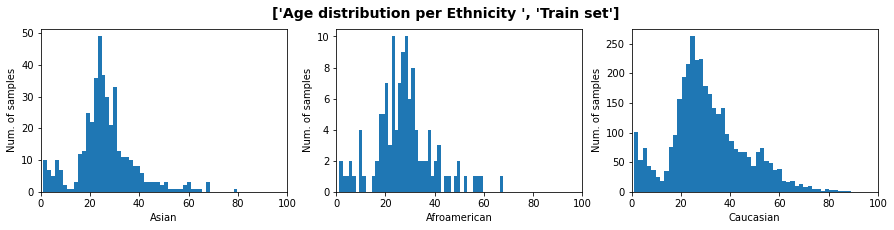

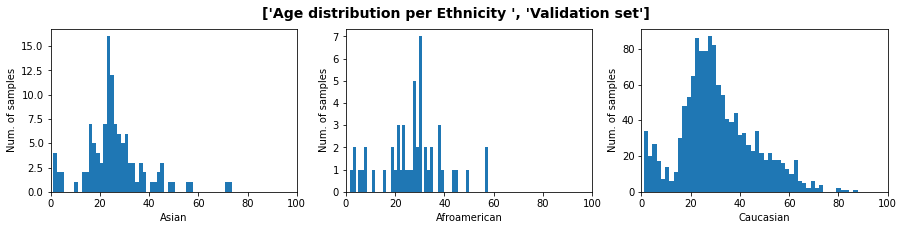

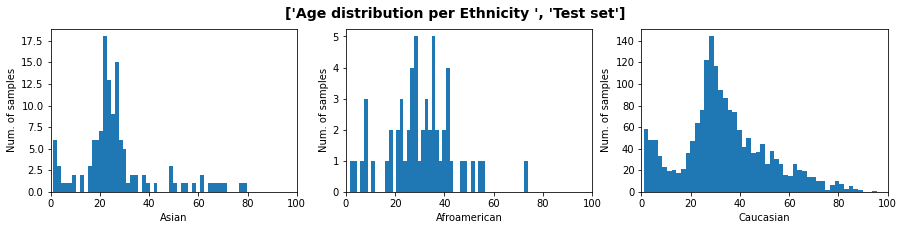

In [ ]:
# train set
compute_hist_per_ethnicity(Y_train*100, M_train, 'Train set')

# validation set
compute_hist_per_ethnicity(Y_valid*100, M_valid, 'Validation set')

# test set
# note, we do not multiply 'Y_test' by 100 because it was not normalized 
# to be in the range of [0,1] as the train and validation sets.
compute_hist_per_ethnicity(Y_test, M_test, 'Test set')

# Preprocessing the data (face images)
- Later, we will define our model based on ResNet50 (our backbone). Originally,
ResNet50 uses a regularization that changes the range of the input images. Thus,
to be aligned with the ResNet50 input, we preprocess our input images using the respective 'preprocess_input' function. Later, if you decide to use another model as backbone (rather than ResNet), you may skip the following preprocessing stage.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# train
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = preprocess_input(x)

# validation
for i in range(0,X_valid.shape[0]):
  x = X_valid[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_valid[i,] = preprocess_input(x)  

# test
for i in range(0,X_test.shape[0]):
  x = X_test[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_test[i,] = preprocess_input(x)  

# Downloading the ResNet50 model pre-trained on Faces
We are using ResNet50 pre-trained on Faces (source [here](https://github.com/ox-vgg/vgg_face2))

In [ ]:
# downloading the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip

# decompressing the data
with ZipFile('model.zip','r') as zip:
   zip.extractall()
   print('Model decompressed successfully')

# removing the .zip file after extraction  to clean space
!rm model.zip

--2021-09-20 16:11:35--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107893665 (103M) [application/zip]
Saving to: ‘model.zip’

model.zip           100%[===================>] 102.89M  8.53MB/s    in 13s     

2021-09-20 16:11:49 (7.82 MB/s) - ‘model.zip’ saved [107893665/107893665]

Model decompressed successfully


# Loading the pre-trained model
- You can see the data (e.g., we have downloaded) and structure of Colab by clicking on 'Files', on the left side <-- of this interface.



In [ ]:
import h5py

#JOSE: Had to add this code, it is commented so it does not interfere. 
#This is to prevent an error that appears later, I have posted a message in that cell in capital letters
import tensorflow as tf
'''
#Solution 1: Failed
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

#Solution 2: Failed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#Solution 3: Failed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
'''

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# loading the pretrained model
model = tf.keras.models.load_model('./model/weights.h5')

# print the model summary
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____________________________________________________________________________________________

# Adapting the model to our needs
- In summary, we will ignore the last layer 'classifier_low_dim' and will include a few other layers on top of our backbone. Here, we also define the activation function we are going to use as output of the last FC layer (Sigmoid, in the case).

In [ ]:
# Using the FC layer before the 'classifier_low_dim' layer as feature vector
fc_512 = model.get_layer('dim_proj').output

# adding a dropout layer to minimize overfiting problems
dp_layer = Dropout(0.5)(fc_512)

# adding a few hidden FC layers to learn hidden representations
fc_128 = Dense(128, activation='relu', name='f_128')(fc_512)
fc_32 = Dense(32, activation='relu', name='f_32')(fc_128)

# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = Dense(1, activation='sigmoid', name='predict')(fc_32)

# building and pringing the final model
model = Model(inputs=model.get_layer('base_input').output,outputs=output)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

# Freezing the first layers to allow the fine-tuning of the last FC layers (only)
- Next, we set some layer to be trainable or not, and print if layers are set to trainable = True or False.


In [ ]:
counter = 0
for layer in model.layers:
  if counter <= 174: 
    layer.trainable = False
  else:
    layer.trainable = True
  print(counter, layer.name, layer.trainable)
  counter +=1

0 base_input False
1 conv1/7x7_s2 False
2 conv1/7x7_s2/bn False
3 activation_1 False
4 max_pooling2d_1 False
5 conv2_1_1x1_reduce False
6 conv2_1_1x1_reduce/bn False
7 activation_2 False
8 conv2_1_3x3 False
9 conv2_1_3x3/bn False
10 activation_3 False
11 conv2_1_1x1_increase False
12 conv2_1_1x1_proj False
13 conv2_1_1x1_increase/bn False
14 conv2_1_1x1_proj/bn False
15 add_1 False
16 activation_4 False
17 conv2_2_1x1_reduce False
18 conv2_2_1x1_reduce/bn False
19 activation_5 False
20 conv2_2_3x3 False
21 conv2_2_3x3/bn False
22 activation_6 False
23 conv2_2_1x1_increase False
24 conv2_2_1x1_increase/bn False
25 add_2 False
26 activation_7 False
27 conv2_3_1x1_reduce False
28 conv2_3_1x1_reduce/bn False
29 activation_8 False
30 conv2_3_3x3 False
31 conv2_3_3x3/bn False
32 activation_9 False
33 conv2_3_1x1_increase False
34 conv2_3_1x1_increase/bn False
35 add_3 False
36 activation_10 False
37 conv3_1_1x1_reduce False
38 conv3_1_1x1_reduce/bn False
39 activation_11 False
40 conv3_1_3x3

# Printing the MODEL (summary) we have just defined

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
base_input (InputLayer)         [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        base_input[0][0]                 
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

# IMPORTANT: Mounting your google drive to save your results
- Colab gives you LIMITED GPU access. Thus, it may kill your process (of training) if you pass a limited amount of training hours. To allow you to save your model while training, you can mount your google drive, as detailed next. This way, if the process is killed, you can (in a new session) load your checkpoints (trained model, from your google drive) and, for example, continue training or make predictions with the model you obtained (even if trained for a few epochs).
- In the following examples, the **the beset model (based on validation loss) is saved in my google drive inside a "/temp/" directory. You will need to addapt this path to your case.** 
- To save time, and to allow you to quickly 'play' and run the notebook, we have pre-trained some models, which are loaded (or not) based on some boolean variables (later, you will need to change/adapt these codes to achive the goals of this course).

In [ ]:
#Jose: I am having issues with this one, set to true to try it out

#--------------------------
MOUNT_GOOGLE_DRIVE = False
#--------------------------

if(MOUNT_GOOGLE_DRIVE==True):
  from google.colab import drive
  drive.mount('/content/drive/MyDrive/temp')
  # Note, the default path will be: '/content/gdrive/MyDrive/'
  # In my case, the final path will be: '/content/gdrive/MyDrive/temp/' as I
  # created a '/temp/' folder in my google drive for this purpose.

# Training the Model / or downloading a model already trained
- As default, the code below will load a pre-trained model, obtained using the same code if LOAD_BEST_MODEL_ST1 is set to False.
- Later, you can set LOAD_BEST_MODEL_ST1 to False to perfom the training.
  - The code below uses Early stopping (es) with patience = 5 (that is, the training will stop if no improvement on valid_loss is observed on the last 5 epochs).
  - It uses the Mean Squared Error (MSE) as loss function ('loss=tf.keras.losses.MeanSquaredError()'). The code also evaluates the Mean Absolute Error (MAE) during training ('metrics=['mae']'). Learning rate is set to 'learning_rate=1e-5', batch size = 32, and the model will be trained for 50 epochs (if Colab allows it based to the time budget)
  - The model callback (mc) is set to save the best model based on valid_loss (that is, if validation loss decreases from one epoch to another, a new model is saved on the path you specify).
  - Other hyperparameters you can play with are: defining another optimizer, loss function, learning rate, batch size, num of epochs.

- Note: in case you want to save your model, stop training, and resume training, check the end of this file **"II) illustrating how to train + save + stop training + RESUME TRAINING"** where we provide a more detailed example about this procedure. Recommendation: first train your model for a few epochs to avoid the need of resume training. This way, you will get used with the code and the general pipeline. Later, you can play with that.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# load a model and train history (defined and trained
# as below, trained for 38 epochs)
#--------------------------
LOAD_BEST_MODEL_ST1 = True # (training only the last FC layers)
#--------------------------


if(LOAD_BEST_MODEL_ST1==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st1.zip
  # decompressing the data
  with ZipFile('best_model_st1.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st1.zip
  
else:
  # defining the early stop criteria
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model based on val_loss
  mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

  # defining the optimizer
  model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # training the model
  history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=32, epochs=50, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history (for future visualization)
  with open('/content/gdrive/MyDrive/temp/train_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

--2021-09-20 16:12:52--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st1.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100009889 (95M) [application/zip]
Saving to: ‘best_model_st1.zip’

best_model_st1.zip  100%[===================>]  95.38M  5.82MB/s    in 15s     

2021-09-20 16:13:08 (6.23 MB/s) - ‘best_model_st1.zip’ saved [100009889/100009889]

Model decompressed successfully


# Visualizing the train history


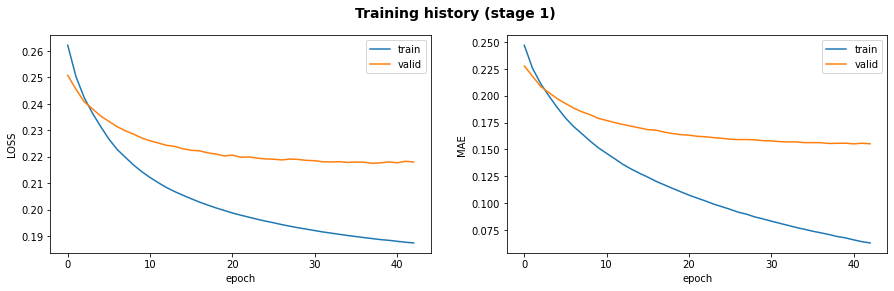

In [ ]:
import pickle
from matplotlib import pyplot as plt

# here, it loads the history of the model we have already trained, or loads the 
# history of the model you defined and trained
if(LOAD_BEST_MODEL_ST1==True):
  train_hist = pickle.load(open("train_history.pkl","rb"))
else:
  train_hist = pickle.load(open("/content/gdrive/MyDrive/temp/train_history.pkl","rb"))

# we plot both, the LOSS and MAE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='LOSS')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')  


# Loading the saved model and Making predictions on the Test set
- Next, we load the trained model and make predictions on the Test set


In [ ]:
#JOSE: THIS IS THE CELL THAT DOES NOT WORK on GPU
from tensorflow.keras.models import load_model

#--------------------------
ENABLE_EVALUATION_ST1 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST1==True):
  saved_model = load_model('best_model.h5')
else:
  saved_model = load_model('/content/gdrive/MyDrive/temp/best_model.h5')

if(ENABLE_EVALUATION_ST1==True):
  # predict on the test data
  predictions_st1 = saved_model.predict(X_test, batch_size=32, verbose=1)

62/62 [==============================] - 266s 4s/step


# Evaluating the model on the Test set, using the Mean Absolute Error (MAE) as metric.
- Note, as the train/validation labels were re-scaled to be in the range of [0,1], the predictions will be in the same range [0,1]. 
- To evaluate the model on the test set (which was not normalized), we re-scale the predictions back using the normalization factor = 100 (previously defined), in order to have the Mean Absolute Error with respect to the original apparent age labels.

In [ ]:
if(ENABLE_EVALUATION_ST1==True):
  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_st1_f = predictions_st1*100

  # evaluating on test data
  error = []
  for i in range(0,len(Y_test)):
    error.append(abs(np.subtract(predictions_st1_f[i][0],Y_test[i])))

  print('MAE = %.8f' %(np.mean(error)))

MAE = 16.98603741


In [ ]:
if(ENABLE_EVALUATION_ST1==True):
  # printing some predictions
  for i in range(0,10):
    print('predicted age = %.3f - Ground truth = %.3f' %(predictions_st1_f[i], Y_test[i]))

predicted age = 45.214 - Ground truth = 23.205
predicted age = 59.144 - Ground truth = 70.737
predicted age = 29.385 - Ground truth = 55.368
predicted age = 22.383 - Ground truth = 24.278
predicted age = 10.738 - Ground truth = 25.231
predicted age = 65.890 - Ground truth = 35.179
predicted age = 48.566 - Ground truth = 26.923
predicted age = 16.006 - Ground truth = 48.189
predicted age = 5.571 - Ground truth = 18.676
predicted age = 31.697 - Ground truth = 57.378


---
# Performing a 2nd Stage of training, where ALL Layers are set to "trainable"
- Up to here, we have just trained the last FC layers of our model. Now, we will load the model we have trained (referred to it as 1st stage), set all layers to TRAINABLE, and train the whole model. Training will take more time, but we expect to get better results.

In [ ]:
# setting all layers of the model to trainable
saved_model.trainable = True

counter = 0
for layer in saved_model.layers:
  print(counter, layer.name, layer.trainable)
  counter +=1

0 base_input True
1 conv1/7x7_s2 True
2 conv1/7x7_s2/bn True
3 activation_1 True
4 max_pooling2d_1 True
5 conv2_1_1x1_reduce True
6 conv2_1_1x1_reduce/bn True
7 activation_2 True
8 conv2_1_3x3 True
9 conv2_1_3x3/bn True
10 activation_3 True
11 conv2_1_1x1_increase True
12 conv2_1_1x1_proj True
13 conv2_1_1x1_increase/bn True
14 conv2_1_1x1_proj/bn True
15 add_1 True
16 activation_4 True
17 conv2_2_1x1_reduce True
18 conv2_2_1x1_reduce/bn True
19 activation_5 True
20 conv2_2_3x3 True
21 conv2_2_3x3/bn True
22 activation_6 True
23 conv2_2_1x1_increase True
24 conv2_2_1x1_increase/bn True
25 add_2 True
26 activation_7 True
27 conv2_3_1x1_reduce True
28 conv2_3_1x1_reduce/bn True
29 activation_8 True
30 conv2_3_3x3 True
31 conv2_3_3x3/bn True
32 activation_9 True
33 conv2_3_1x1_increase True
34 conv2_3_1x1_increase/bn True
35 add_3 True
36 activation_10 True
37 conv3_1_1x1_reduce True
38 conv3_1_1x1_reduce/bn True
39 activation_11 True
40 conv3_1_3x3 True
41 conv3_1_3x3/bn True
42 activati

# Training the WHOLE Model (2nd Stage)

- As default, the code below will load a pre-trained model, obtained using the same code if LOAD_BEST_MODEL_ST2 is set to False.
- Later, you can set LOAD_BEST_MODEL_ST2 to False to perfom the training.
  - As before, the code below uses Early stopping (es) with patience = 5 (that is, the training will stop if no improvement on valid_loss is observed on the last 5 epochs).
  - It uses the Mean Squared Error (MSE) as loss function ('loss=tf.keras.losses.MeanSquaredError()'). The code also evaluates the Mean Absolute Error (MAE) during training ('metrics=['mae']'). Learning rate is set to 'learning_rate=1e-5', batch size = 16, and the model will be trained for 12 epochs (if Colab allows it based to the time budget). Note, if you increase the batch size too much, data may not fit the GPU capacity (as the number of parameters to train increased compared to the 1st stage). This is why we reduced it from 32 to 16.
  - The model callback (mc) is set to save the best model based on valid_loss (that is, if validation loss decreases from one epoch to another, a new model is saved on the path you specify).
  - Other hyperparameters you can play with are: defining another optimizer, loss function, learning rate, batch size, num of epochs.
- WARNING: at this stage, training take more time, and colab may close before you finish training due to time constraints. Thus, you will need to define a good strategy! In case you want to save your model, stop training, and resume training, check the end of this file **"II) illustrating how to train + save + stop training + RESUME TRAINING"** where we provide a more detailed example about this procedure.
- WARNING: if you save your model and resume training, the train history will be lost. To monitore the training history, you may need to save the train history in another way (e.g., you can copy and paste the logs into a text file before resuming the training).

In [ ]:
# Loding a pretrained model or train
#--------------------------
LOAD_BEST_MODEL_ST2 = True
#--------------------------

if(LOAD_BEST_MODEL_ST2==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2.zip
  # decompressing the data
  with ZipFile('best_model_st2.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st2.zip

else:
  
  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # defining the early stop criteria
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  # saving the best model (2nd stage) based on val_loss with a different name
  mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=12, shuffle=True, verbose=1, callbacks=[es,mc])

  # saving training history
  with open('/content/gdrive/MyDrive/temp/train_history_2nd_stage.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)



--2021-09-20 16:17:41--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271392330 (259M) [application/zip]
Saving to: ‘best_model_st2.zip’

best_model_st2.zip  100%[===================>] 258.82M  4.96MB/s    in 46s     

2021-09-20 16:18:28 (5.57 MB/s) - ‘best_model_st2.zip’ saved [271392330/271392330]

Model decompressed successfully


# Visualizing the Training history of both stages (1st stage and 2nd stage)
- Next, we show the train history of the models we have already trained for this course.
- The curves of both stages are concatenated. You can observe a peak around epoch 42 (dashed line), which indicates the end of the first stage of training and the start of the 2nd stage, and how the 2nd stage improves the performance with respect to validation loss.

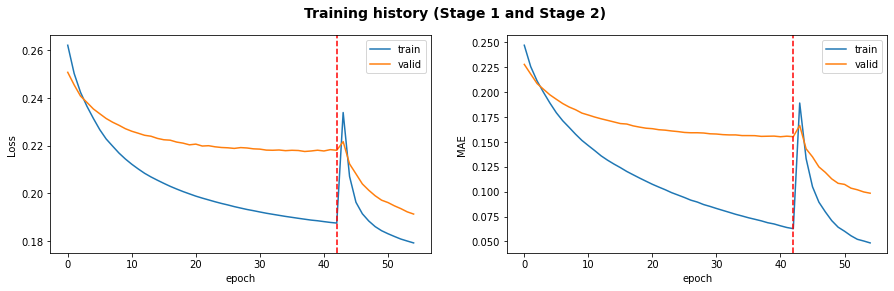

In [ ]:
if(LOAD_BEST_MODEL_ST1==True and LOAD_BEST_MODEL_ST2==True):
  train_hist = pickle.load(open("train_history.pkl","rb"))
  train_hist_2nd = pickle.load(open("train_history_2nd_stage.pkl","rb"))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
  fig.suptitle('Training history (Stage 1 and Stage 2)', fontsize=14, fontweight='bold')

  ax1.plot(train_hist['loss']+train_hist_2nd['loss'])
  ax1.plot(train_hist['val_loss']+train_hist_2nd['val_loss'])
  ax1.axvline(42, 0, 1, ls='--', color='r')
  ax1.set(xlabel='epoch', ylabel='Loss')
  ax1.legend(['train', 'valid'], loc='upper right')

  ax2.plot(train_hist['mae']+train_hist_2nd['mae'])
  ax2.plot(train_hist['val_mae']+train_hist_2nd['val_mae'])
  ax2.axvline(42, 0, 1, ls='--', color='r')
  ax2.set(xlabel='epoch', ylabel='MAE')
  ax2.legend(['train', 'valid'], loc='upper right')

# Evaluating the model lerned at the 2nd stage on the test set
- Here, you can observe a decrease in Mean Absolute Error (MAE) compared to the predictions obtained with the model trained at the 1st stage (from MAE = 16.98603930 to MAE = 11.14126198).

In [ ]:
#--------------------------
ENABLE_EVALUATION_ST2 = True
#--------------------------

# loading the saved model
if(LOAD_BEST_MODEL_ST2 == True):
  saved_model_2nd = load_model('best_model_2nd_stage.h5')
else:
  saved_model_2nd = load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage.h5')


if(ENABLE_EVALUATION_ST2==True):
  # predict on the test data
  predictions_2nd = saved_model_2nd.predict(X_test, batch_size=32, verbose=1)

  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_2nd_f = predictions_2nd*100

62/62 [==============================] - 264s 4s/step


In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # evaluating on test data
  error = []
  for i in range(0,len(Y_test)):
    error.append(abs(np.subtract(predictions_2nd_f[i][0],Y_test[i])))

  print('MAE = %.8f' %(np.mean(error)))

MAE = 11.14126454


In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # printing some predictions
  for i in range(0,10):
    print('predicted age = %.3f - Ground truth = %.3f' %(predictions_2nd_f[i], Y_test[i]))

predicted age = 45.627 - Ground truth = 23.205
predicted age = 53.100 - Ground truth = 70.737
predicted age = 39.646 - Ground truth = 55.368
predicted age = 21.656 - Ground truth = 24.278
predicted age = 24.649 - Ground truth = 25.231
predicted age = 27.901 - Ground truth = 35.179
predicted age = 13.701 - Ground truth = 26.923
predicted age = 24.841 - Ground truth = 48.189
predicted age = 20.201 - Ground truth = 18.676
predicted age = 45.143 - Ground truth = 57.378


---
# Saving the predicted values (on Test set) to be uploaded on Codalab Competition
- Next, we show how you can save your predictions (on the test set) so that they can be submitted to our Codalab Competition.
- Note, the .csv file MUST be named **'predictions.csv'**, othwerwise you will get an error on Codalab.
- The generated zip file can be submitted on codalab ( <- you can download in from the left part of this web interface).
- You can reuse and adapt this code to generate a submission file for the different results you will obtain during the course. At the end of this page we provide additional details about how to make a submission and how to name your .zip file so that we can easily compare all submissions given the different stages.

> To enter the competition you need to create an account on Codalab, and submit your predictions to our challenge: https://competitions.codalab.org/competitions/34499?secret_key=b5788bf1-0102-473a-bf69-b12b27a6f841

In [ ]:
import csv

if(ENABLE_EVALUATION_ST2==True):
  # saving the predictions as a csv file
  with open('predictions.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(predictions_2nd_f)
  csvFile.close()

  # compressing the csv file (to be submitted to codalab as prediction)
  ! zip predictions.zip predictions.csv

  adding: predictions.csv (deflated 55%)


---
---
# Accuracy is not enough! We also need to evaluate how biased is our model!
- Next, we define different different functions, used to compute a bias score given different attributes.
  - Age bias
  - Gender bias
  - Ethnicity bias
  - Facial Expression bias
- In a nutshell, given a particular attribute, we compute the MAE for different groups. For the case of age, detailed next, we will have 4 groups base on different age ranges. Then, we will have $MAE_1$, $MAE_2$, $MAE_3$ and $MAE_4$. Then, we compute the Absolute Difference among all. That is,
  - $D_{1,2} = |MAE_1-MAE_2|$
  - $D_{1,3} = |MAE_1-MAE_3|$
  - $D_{1,4} = |MAE_1-MAE_4|$
  - $D_{2,3} = |MAE_2-MAE_3|$
  - $D_{2,4} = |MAE_2-MAE_4|$
  - $D_{3,4} = |MAE_3-MAE_4|$

- The final score is obtained by the average of the absolute differentes. In the case of age:
  - $B_a = (D_{1,2} + D_{1,3} + D_{1,4} + D_{2,3} + D_{2,4} + D_{3,4})/6$

- To minimize your bias score, given a particular attribute, you will need to minimize the Absolute Difference among the different groups being evaluated.
- The big challenge here is to minimize ALL bias scores (i.e., age, gender, ethnicity and face expression).

---
# Age Bias ($B_a$) 

- Evaluates (on the TEST set) how accurate the model is with respect to different age ranges.
  - group 1: age < 20
  - group 2: 20 <= age < 40
  - group 3: 40 <= age < 60
  - group 4: 60 <= age



In [ ]:
def age_bias(predictions, gt):
  error_g1 = []
  error_g2 = []
  error_g3 = []
  error_g4 = []
  for i in range(0,len(gt)):
    if(gt[i]<20):
      error_g1.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=20 and gt[i]<40):
      error_g2.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=40 and gt[i]<60):
      error_g3.append(abs(predictions[i]-gt[i]))
    if(gt[i]>=60):
      error_g4.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Age analysis:')
  print('Size group 1 = %d, MAE = %f' %(len(error_g1), np.mean(error_g1)))
  print('Size group 2 = %d, MAE = %f' %(len(error_g2), np.mean(error_g2)))
  print('Size group 3 = %d, MAE = %f' %(len(error_g3), np.mean(error_g3)))
  print('Size group 4 = %d, MAE = %f' %(len(error_g4), np.mean(error_g4)))

  age_bias = (abs(np.mean(error_g1)-np.mean(error_g2)) +
            abs(np.mean(error_g1)-np.mean(error_g3)) +
            abs(np.mean(error_g1)-np.mean(error_g4)) +
            abs(np.mean(error_g2)-np.mean(error_g3)) +
            abs(np.mean(error_g2)-np.mean(error_g4)) +
            abs(np.mean(error_g3)-np.mean(error_g4)))/6

  print('---------')
  print('Age bias (Ba) = ', age_bias)

# Gender Bias ($B_g$) 
- Evaluates (on the test set) how accurate the model is with respect to different gender.
  - group 1: male
  - group 2: female


In [ ]:
def gender_bias(predictions, gt, metadata):
  error_m = []
  error_f = []
  for i in range(0,len(gt)):
    if(metadata[i][0] == 'female'):
      error_f.append(abs(predictions[i]-gt[i]))
    else:
      error_m.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Gender analysis:')
  print('Size group female = %d, MAE = %f' %(len(error_f), np.mean(error_f)))
  print('Size group male = %d, MAE = %f' %(len(error_m), np.mean(error_m)))

  gender_bias = abs(np.mean(error_f)-np.mean(error_m))

  print('---------')
  print('Gender bias (Bg) = ', gender_bias)

# Ethnicity Bias ($B_e$)
- Evaluates (on the test set) how accurate the model is with respect to different ethnicity categories.
  - group 1: asian
  - group 2: afroamerican
  - group 3: caucasian


In [ ]:
def ethnicity_bias(predictions, gt, metadata):
  error_as = []
  error_af = []
  error_ca = []
  for i in range(0,len(gt)):
    if(metadata[i][1] == 'asian'):
      error_as.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'afroamerican'):
      error_af.append(abs(predictions[i]-gt[i]))
    if(metadata[i][1] == 'caucasian'):
      error_ca.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Ethnicity Analysis:')
  print('Size group asian = %d, MAE = %f' %(len(error_as), np.mean(error_as)))
  print('Size group afroamerican = %d, MAE = %f' %(len(error_af), np.mean(error_af)))
  print('Size group caucasian = %d, MAE = %f' %(len(error_ca), np.mean(error_ca)))
  
  ethnicity_bias = (abs(np.mean(error_as)-np.mean(error_af)) +
                   abs(np.mean(error_as)-np.mean(error_ca)) +
                   abs(np.mean(error_af)-np.mean(error_ca)))/3

  print('---------')
  print('Ethnicity bias (Be) = ', ethnicity_bias)

# Face expression bias ($B_f$)
- Evaluates (on the test set) how accurate the model is with respect to different face expression categories.
  - group 1: neutral
  - group 2: slightlyhappy
  - group 3: happy
  - group 4: other


In [ ]:
def face_expression_bias(predictions, gt, metadata):
  error_h = []
  error_s = []
  error_n = []
  error_o = []
  for i in range(0,len(gt)):
    if(metadata[i][2]=='happy'):
      error_h.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='slightlyhappy'):
      error_s.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='neutral'):
      error_n.append(abs(predictions[i]-gt[i]))
    if(metadata[i][2]=='other'):
      error_o.append(abs(predictions[i]-gt[i]))

  print('=============================')
  print('Face experession Analysis:')
  print('Size group happy = %d, MAE = %f' %(len(error_h), np.mean(error_h)))
  print('Size group slightlyhappy = %d, MAE = %f' %(len(error_s), np.mean(error_s)))
  print('Size group neutral = %d, MAE = %f' %(len(error_n), np.mean(error_n)))
  print('Size group other = %d, MAE = %f' %(len(error_o), np.mean(error_o)))

  face_bias = (abs(np.mean(error_h)-np.mean(error_s)) +
              abs(np.mean(error_h)-np.mean(error_n)) +
              abs(np.mean(error_h)-np.mean(error_o)) +
              abs(np.mean(error_s)-np.mean(error_n)) +
              abs(np.mean(error_s)-np.mean(error_o)) +
              abs(np.mean(error_n)-np.mean(error_o)))/6

  print('---------')
  print('Face Expression bias (Bf) = ', face_bias)




---
# Computing the Age, Gender and Ethnicity Biases on the Test set
- Next, we compute the different bias scores using the model we obtained after the 2nd stage of training.

In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # computing the age bias (model_stage_2)
  age_bias(predictions_2nd_f,Y_test)

  # computing the gender bias (model_stage_2)
  gender_bias(predictions_2nd_f,Y_test,M_test)

  # computing the ethnicity bias (model_stage_2)
  ethnicity_bias(predictions_2nd_f,Y_test,M_test)

  # computing the face bias (model_stage_2)
  face_expression_bias(predictions_2nd_f,Y_test,M_test)

Age analysis:
Size group 1 = 369, MAE = 11.291869
Size group 2 = 1044, MAE = 8.094768
Size group 3 = 390, MAE = 12.658478
Size group 4 = 175, MAE = 25.617014
---------
Age bias (Ba) =  8.9888916015625
Gender analysis:
Size group female = 1020, MAE = 10.837106
Size group male = 958, MAE = 11.465108
---------
Gender bias (Bg) =  0.62800217
Ethnicity Analysis:
Size group asian = 129, MAE = 10.345762
Size group afroamerican = 56, MAE = 7.636685
Size group caucasian = 1793, MAE = 11.307956
---------
Ethnicity bias (Be) =  2.4475138982137046
Face experession Analysis:
Size group happy = 589, MAE = 11.054638
Size group slightlyhappy = 505, MAE = 11.176367
Size group neutral = 756, MAE = 10.947430
Size group other = 128, MAE = 12.546234
---------
Face Expression bias (Bf) =  0.8196903864542643


---
---
# Strategies to improve Accuracy (i.e., to reduce the Error): 
- We will comment about two different strategies: 1) data augmentation and 2) custom loss with weighted samples.

# 1) Data augmentation
- Next, we will augment the train set of people having age >= 60, as this group got the highest MAE compared to the other groups (regarding the age attribute only). 
- Different data augmentation strategies can be used. In this example, we  consider horizontal flip, changing the brighness, gaussian blur and translation.

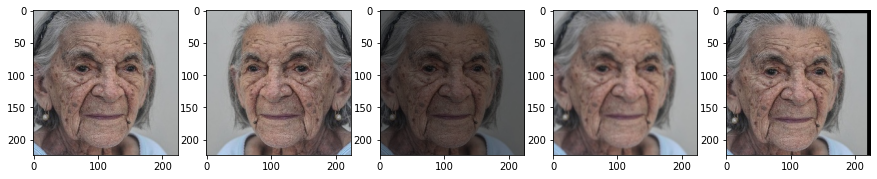

In [ ]:
# loading the train data again (original face images, before preprocessing):
X_train = np.load('./data/data_train.npy')

# Randomly selecting a random image from train set
x = X_train[random.randint(0, len(X_train))]

# flip horizontaly
x_flipped = cv2.flip(x, 1)

# change brightness
x_brigth = cv2.cvtColor(x,cv2.COLOR_RGB2HSV)
x_brigth[:,:,2] = x_brigth[:,:,2]*.5+np.random.uniform()
x_brigth = cv2.cvtColor(x_brigth,cv2.COLOR_HSV2RGB)

# gaussian blur (here you can also play with the function parameters)
x_blur = cv2.GaussianBlur(x,(5,5),1.0)

# translation (randomly translation from -25 to +25 in x and y)
rows, cols ,c= x.shape
M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
x_translate = cv2.warpAffine(x, M, (cols, rows))

# Visualizing the augmented data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 15))
ax1.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB)) # original image
ax2.imshow(cv2.cvtColor(x_flipped, cv2.COLOR_BGR2RGB)) # flip horizontaly
ax3.imshow(cv2.cvtColor(x_brigth, cv2.COLOR_BGR2RGB)) # change brightness
ax4.imshow(cv2.cvtColor(x_blur, cv2.COLOR_BGR2RGB)) # gaussian blur
ax5.imshow(cv2.cvtColor(x_translate, cv2.COLOR_BGR2RGB)) # translation

# Applying the data augmentation described above
- Note, for each augmented image, we replicate its original label.

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
# aux variables
X_train_augmented = []
Y_train_augmented = []

# loading the train data and labels
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100
print('Train set before augmentation = ', np.array(X_train).shape)

# augmenting the data
for i in range(0,len(X_train)):
  # check if image is in the group 'age >= 60'

  if Y_train[i]*100>=60: # here labels are multiplied by 100 as they were normalized to be between [0,1]
    # flip
    X_train_augmented.append(cv2.flip(X_train[i], 1))
    Y_train_augmented.append(Y_train[i]) 

    # changing brightness
    x_aux = cv2.cvtColor(X_train[i],cv2.COLOR_RGB2HSV)
    x_aux[:,:,2] = x_aux[:,:,2]*.5+np.random.uniform()
    X_train_augmented.append(cv2.cvtColor(x_aux,cv2.COLOR_HSV2RGB))
    Y_train_augmented.append(Y_train[i]) 

    # blur
    X_train_augmented.append(cv2.GaussianBlur(X_train[i],(5,5),1.0))
    Y_train_augmented.append(Y_train[i])
   
    # translation
    rows, cols ,c= X_train[i].shape
    M = np.float32([[1, 0, random.randint(-25, 25)], [0, 1, random.randint(-25, 25)]])
    X_train_augmented.append(cv2.warpAffine(X_train[i], M, (cols, rows)))
    Y_train_augmented.append(Y_train[i])

# adding the augmented images to the train set
X_train = np.concatenate((X_train, X_train_augmented))
Y_train = np.concatenate((Y_train, Y_train_augmented))
print('Train set after augmentation = ', np.array(X_train).shape)


# post-processing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = preprocess_input(x)

Train set before augmentation =  (4065, 224, 224, 3)
Train set after augmentation =  (4657, 224, 224, 3)


---
# Training the 2nd stage again, from the model obtained at the 1st stage, but now using the augmented data
- As before, we provide a model already trained (using the augmented data), which will be loaded as default if the code below is not changed. 
- You can change the boolean variable LOAD_BEST_MODEL_ST2_AUGMENTATION from True to False in order to train the model again, given your redefined strategy.

In [ ]:
#--------------------------
LOAD_BEST_MODEL_ST2_AUGMENTATION = True
#--------------------------

if(LOAD_BEST_MODEL_ST2_AUGMENTATION==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2_aug.zip
  # decompressing the data
  with ZipFile('best_model_st2_aug.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_st2_aug.zip

else:
  # loading the saved model (best model learned at stage 1)
  saved_model = load_model('best_model.h5')
  
  # setting all layers to traineble
  saved_model.trainable = True

  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])

  # defining the early stop criteria
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  
  # saving the best model (2nd stage) based on val_loss with a different name
  mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5', monitor='val_loss', mode='min', save_best_only=True)

  history = saved_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), batch_size=16, epochs=12, shuffle=True, verbose=1, callbacks=[es,mc])
  

--2021-09-20 16:23:08--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_st2_aug.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271383554 (259M) [application/zip]
Saving to: ‘best_model_st2_aug.zip’

best_model_st2_aug. 100%[===================>] 258.81M  9.37MB/s    in 33s     

2021-09-20 16:23:42 (7.92 MB/s) - ‘best_model_st2_aug.zip’ saved [271383554/271383554]

Model decompressed successfully


# Train History of the provided pre-trained model

Epoch 1/12
292/292 [==============================] - 3358s 11s/step - loss: 0.2493 - mae: 0.2113 - val_loss: 0.2226 - val_mae: 0.1681

Epoch 2/12
292/292 [==============================] - 3390s 12s/step - loss: 0.2098 - mae: 0.1414 - val_loss: 0.2137 - val_mae: 0.1467

Epoch 3/12
292/292 [==============================] - 3310s 11s/step - loss: 0.1978 - mae: 0.1089 - val_loss: 0.2094 - val_mae: 0.1385

Epoch 4/12
292/292 [==============================] - 3284s 11s/step - loss: 0.1926 - mae: 0.0935 - val_loss: 0.2046 - val_mae: 0.1280

Epoch 5/12
292/292 [==============================] - 3142s 11s/step - loss: 0.1896 - mae: 0.0838 - val_loss: 0.2022 - val_mae: 0.1219

Epoch 6/12
292/292 [==============================] - 3072s 11s/step - loss: 0.1872 - mae: 0.0762 - val_loss: 0.1999 - val_mae: 0.1166

Epoch 7/12
292/292 [==============================] - 3006s 10s/step - loss: 0.1849 - mae: 0.0684 - val_loss: 0.1977 - val_mae: 0.1116

Epoch 8/12
292/292 [==============================] - 3029s 10s/step - loss: 0.1834 - mae: 0.0631 - val_loss: 0.1964 - val_mae: 0.1093

Epoch 9/12
292/292 [==============================] - 3043s 10s/step - loss: 0.1821 - mae: 0.0578 - val_loss: 0.1953 - val_mae: 0.1065

Epoch 10/12
292/292 [==============================] - 2591s 9s/step - loss: 0.1817 - mae: 0.0592 - val_loss: 0.1938 - val_mae: 0.1054

Epoch 11/12
292/292 [==============================] - 2541s 9s/step - loss: 0.1807 - mae: 0.0575 - val_loss: 0.1904 - val_mae: 0.0978

Epoch 12/12
292/292 [==============================] - 2421s 8s/step - loss: 0.1788 - mae: 0.0542 - val_loss: 0.1870 - val_mae: 0.0906

# Evaluating the model (with data augmentation) on Test set
- Here, you can observe a decrease in Mean Absolute Error (MAE) compared to the predictions obtained by the previously trained models:
  - Model trained at the 1st stage: MAE = 16.98603930
  - Model trained at the 2nd stage (without data augmentation): MAE = 11.14126198
  - Model trained at the 2nd stage (with data augmentation): MAE = 10.28505150

In [ ]:
# loading the saved model
if(LOAD_BEST_MODEL_ST2_AUGMENTATION==True):
  saved_model_2nd_augm = load_model('best_model_2nd_stage_augmentation.h5')
else:
  saved_model_2nd_augm = load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_augmentation.h5')


#--------------------------
ENABLE_EVALUATION_ST2_AUGMENTED = True
#--------------------------

if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
  # predict on the test data
  predictions_2nd_augmented = saved_model_2nd_augm.predict(X_test, batch_size=32, verbose=1)
  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_2nd_augmented_f = predictions_2nd_augmented*100


62/62 [==============================] - 262s 4s/step


In [ ]:
if(ENABLE_EVALUATION_ST2_AUGMENTED==True):
  # evaluating on test data
  error = []
  for i in range(0,len(Y_test)):
    error.append(abs(np.subtract(predictions_2nd_augmented_f[i][0],Y_test[i])))

  print('MAE = %.8f' %(np.mean(error)))

MAE = 10.28504908


# Computing the Age Bias (augmented data)
- Next, if we compare the age bias obtained by the two models (without/with) data augmentation, we can observed the model with augmented data was able to recude the age bias (from 8.988896687825521 to 5.779014587402344). In particular, the MAE for group 4 reduced from 25.617018 to 19.334185, suggesting that our data augmentation had a positive impact in training.

In [ ]:
if(ENABLE_EVALUATION_ST2==True):
  # computing the age bias (model_stage_2) - previous model without data augmentation
  age_bias(predictions_2nd_f,Y_test)

if(ENABLE_EVALUATION_ST2_AUGMENTED==True):  
  # computing the age bias (model_stage_2) - with data augmentation
  age_bias(predictions_2nd_augmented_f,Y_test)

Age analysis:
Size group 1 = 369, MAE = 11.291869
Size group 2 = 1044, MAE = 8.094768
Size group 3 = 390, MAE = 12.658478
Size group 4 = 175, MAE = 25.617014
---------
Age bias (Ba) =  8.9888916015625
Age analysis:
Size group 1 = 369, MAE = 11.260430
Size group 2 = 1044, MAE = 7.909565
Size group 3 = 390, MAE = 11.660667
Size group 4 = 175, MAE = 19.334185
---------
Age bias (Ba) =  5.779015858968099


---
---
# Strategies to improve Accuracy (i.e., to reduce the Error):
# 2) Custom Loss: sample weights to deal with inbalanced categories
- Next, we will created a "customized loss", which gives more weight to people having less samples in train data. For this, **we will consider the age range only**. This way, we believe the model will be able to generalize a little bit better to those particular groups.

# Load the Train data again (to remove the augmented data) and generate the weigths 
- First, we will generate a weight for each age group (for g =1 to 4);
- The formula used to calculate the weight for each group $j$ is:

  $w_j=n_{samples} / (n_{classes} * n_{samples,j}),$

  Where

    - $w_j$ is the weight for each group $j$,
    - $n_{samples}$ is the number of samples in the train set,
    - $n_{classes}$ is the number of classes (4 in our case, as we divided the ages in 4 groups),
    - $n_{samples,j}$ is the number of samples of class (group) $j$.


In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
# loading the train data again (original face images, before preprocessing):
X_train = np.load('./data/data_train.npy')
Y_train = np.load('./data/labels_train.npy')
Y_train = Y_train/100 # normalizing the age values to be between [0,1]

# preprocessing the train data with respect to ResNet-50 Inputs.
for i in range(0,X_train.shape[0]):
  x = X_train[i,:,:,:]
  x = np.expand_dims(x, axis=0)
  X_train[i,] = preprocess_input(x)

# counting the number of samples per group in the train data (age attribute only)
g1 = g2 = g3 = g4 = 0
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      g1 +=1
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      g2 +=1
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      g3 +=1
    if(Y_train[i]*100>=60):
      g4 +=1
print('group(s) size = ', [g1, g2, g3, g4])

# generating the weights for each group using the equation defined above
w = sum(np.array([g1, g2, g3, g4]))/(4*np.array([g1, g2, g3, g4]))
print('weights per group = ', w)

# creating a vector with same size as Y_train, that will link a particular label to its weight
sample_weights = []
for i in range(0,Y_train.shape[0]):
    if(Y_train[i]*100<20):
      sample_weights.append(w[0])
    if(Y_train[i]*100>=20 and Y_train[i]*100<40):
      sample_weights.append(w[1])
    if(Y_train[i]*100>=40 and Y_train[i]*100<60):
      sample_weights.append(w[2])
    if(Y_train[i]*100>=60):
      sample_weights.append(w[3])
sample_weights = np.array(sample_weights)

group(s) size =  [796, 2389, 732, 148]
weights per group =  [1.27669598 0.42538719 1.38831967 6.86655405]


# I) Using the SAMPLE WEIGHTS to train our model and,
- Next, you will see the code we used to train our model (2nd stage) from the model we obtained at the 1st stage, using the customized loss option with sample weights.
- As default, the code will load the model already trained. 
- You can change the boolean variable 'LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS' to False to train your model.
- Note, now we include other variables ('RESUME_TRAINING' and 'RESUME_FROM_EPOCH') to allow us resuming training, as well as to inform from what epoch we want to resume the trainind, detailed below.

# II) illustrating how to train + save + stop training + RESUME TRAINING
- **Imagine** you set 'LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS = False', 'NUM_EPOCHS = 12' and 'RESUME_TRAINING = False' to train your model the first time.
- Due to Colab limitations, your process stoped the training at the middle of epoch 10, and you saved the best model based on validation loss on epoch 9.
- In the above example, you can resume training from epoch 9 by setting the following parameters:
  - 'RESUME_TRAINING = True'
  - 'RESUME_FROM_EPOCH = 9'

- IMPORTANT: to resume training, you will need to monitor the epoch number where your model stopped before resuming the training, and change the defined variables properly. 
  - Note that the fit function is adapted to receive the sample weights ('sample_weight=sample_weights').
  - Also note that the fit function changes if you are training from epoch 0 (initial_epoch=0) or resume training (initial_epoch=RESUME_FROM_EPOCH). 
  - Finally, note that when you are resuming training, you load your 'best_model_2nd_stage_weighted.h5' instead of the model trained at stage 1 ('best_model.h5').


In [ ]:
#--------------------------
LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS = True
NUM_EPOCHS = 12
#--------------------------
RESUME_TRAINING = False
RESUME_FROM_EPOCH = 9
#--------------------------

if(LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS==True):
  # downloading the trained model
  !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_weighted.zip
  # decompressing the data
  with ZipFile('best_model_weighted.zip','r') as zip:
    zip.extractall()
    print('Model decompressed successfully')
  # removing the .zip file after extraction  to clean space
  !rm best_model_weighted.zip

else:
  # loading the saved model (best model learned at stage 1)
  if(RESUME_TRAINING == False):
    saved_model = load_model('best_model.h5') # load model from stage 1
  else:
    # resume training (stage 2)
    saved_model = load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')
  
  # setting all layers to traineble
  saved_model.trainable = True

  #=================================================
  # training all layers (2nd stage), given the model saved on stage 1
  saved_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5),loss=tf.keras.losses.MeanSquaredError(),metrics=['mae'])
  #=================================================

  # defining the early stop criteria
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
  mc = ModelCheckpoint('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5', monitor='val_loss', mode='min', save_best_only=True)

  if(RESUME_TRAINING == False):  
    history = saved_model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=0, shuffle=True, verbose=1, callbacks=[es,mc])
  else:
    history = saved_model.fit(X_train, Y_train, sample_weight=sample_weights, validation_data=(X_valid, Y_valid), batch_size=16, epochs=NUM_EPOCHS, initial_epoch=RESUME_FROM_EPOCH, shuffle=True, verbose=1, callbacks=[es,mc])
  

--2021-09-20 16:28:16--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/best_model_weighted.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271396890 (259M) [application/zip]
Saving to: ‘best_model_weighted.zip’

best_model_weighted 100%[===================>] 258.82M  11.5MB/s    in 38s     

2021-09-20 16:28:55 (6.73 MB/s) - ‘best_model_weighted.zip’ saved [271396890/271396890]

Model decompressed successfully


# Making predictions on the Test set and Evaluating
- Note that in this case, the model obtained MAE = 12.45038828, which is not the best score compared to the ones obtained before. However, are the evaluated biases better? Let's see!

In [ ]:
from tensorflow.keras.models import load_model

if(LOAD_BEST_MODEL_ST2_WEIGHTED_LOSS==True):
  saved_model_2nd_weighted = load_model('best_model_2nd_stage_weighted.h5')
else:
  saved_model_2nd_weighted = load_model('/content/gdrive/MyDrive/temp/best_model_2nd_stage_weighted.h5')

#--------------------------
ENABLE_EVALUATION_WEIGHTED = True
#--------------------------

if(ENABLE_EVALUATION_WEIGHTED==True):
  # predict on the test data
  predictions_2nd_weighted = saved_model_2nd_weighted.predict(X_test, batch_size=32, verbose=1)
  # re-scaling the output predictions (from [0,1] to age range) using the
  # the normalization factor mentioned before
  predictions_2nd_weighted_f = predictions_2nd_weighted*100

62/62 [==============================] - 262s 4s/step


In [ ]:
if(ENABLE_EVALUATION_WEIGHTED==True):
  # evaluating on test data
  error = []
  for i in range(0,len(Y_test)):
    error.append(abs(np.subtract(predictions_2nd_weighted_f[i][0],Y_test[i])))

  print('MAE = %.8f' %(np.mean(error)))

MAE = 12.45039057


In [ ]:
# printing some predictions
for i in range(0,20):
  print('predicted age = %.3f - Ground truth = %.3f' %(predictions_2nd_weighted_f[i], Y_test[i]))

predicted age = 46.333 - Ground truth = 23.205
predicted age = 56.602 - Ground truth = 70.737
predicted age = 42.311 - Ground truth = 55.368
predicted age = 19.425 - Ground truth = 24.278
predicted age = 16.771 - Ground truth = 25.231
predicted age = 19.715 - Ground truth = 35.179
predicted age = 10.790 - Ground truth = 26.923
predicted age = 29.985 - Ground truth = 48.189
predicted age = 9.490 - Ground truth = 18.676
predicted age = 41.011 - Ground truth = 57.378
predicted age = 46.650 - Ground truth = 52.150
predicted age = 2.258 - Ground truth = 30.289
predicted age = 1.889 - Ground truth = 30.256
predicted age = 38.848 - Ground truth = 26.526
predicted age = 64.035 - Ground truth = 33.462
predicted age = 54.715 - Ground truth = 69.459
predicted age = 5.798 - Ground truth = 18.763
predicted age = 32.781 - Ground truth = 33.500
predicted age = 20.832 - Ground truth = 42.763
predicted age = 38.073 - Ground truth = 33.056


# Comparing the 2nd stage of training: 
case a) without augmentation and custom loss **VS.** case b) without augmentation but with custom loss.
- Age bias:
  - case a: 8.988896687825521
  - case b: 3.965182622273763
- Gender bias:
  - case a: 0.6280031
  - case b: 0.54932594
- Ethnicity bias:
  - case a: 2.447519620259603
  - case b: 2.094111124674479
- Face Expression bias:
  - case a: 0.8196892738342285
  - case b: 1.220861275990804

As it can be observed, the model with custom loss and weighted samples obtained overall smaller bias scores on all evaluated attributes (except for face expression), even if the weigts were defined based on age attribute only.

In [ ]:
if(ENABLE_EVALUATION_ST2==True and ENABLE_EVALUATION_WEIGHTED==True):
  age_bias(predictions_2nd_f,Y_test)
  age_bias(predictions_2nd_weighted_f,Y_test)

  gender_bias(predictions_2nd_f,Y_test,M_test)
  gender_bias(predictions_2nd_weighted_f,Y_test,M_test)

  ethnicity_bias(predictions_2nd_f,Y_test,M_test)
  ethnicity_bias(predictions_2nd_weighted_f,Y_test,M_test)

  face_expression_bias(predictions_2nd_f,Y_test,M_test)
  face_expression_bias(predictions_2nd_weighted_f,Y_test,M_test)

Age analysis:
Size group 1 = 369, MAE = 11.291869
Size group 2 = 1044, MAE = 8.094768
Size group 3 = 390, MAE = 12.658478
Size group 4 = 175, MAE = 25.617014
---------
Age bias (Ba) =  8.9888916015625
Age analysis:
Size group 1 = 369, MAE = 12.382668
Size group 2 = 1044, MAE = 11.588708
Size group 3 = 390, MAE = 11.744706
Size group 4 = 175, MAE = 19.306410
---------
Age bias (Ba) =  3.9651781717936196
Gender analysis:
Size group female = 1020, MAE = 10.837106
Size group male = 958, MAE = 11.465108
---------
Gender bias (Bg) =  0.62800217
Gender analysis:
Size group female = 1020, MAE = 12.716441
Size group male = 958, MAE = 12.167123
---------
Gender bias (Bg) =  0.5493183
Ethnicity Analysis:
Size group asian = 129, MAE = 10.345762
Size group afroamerican = 56, MAE = 7.636685
Size group caucasian = 1793, MAE = 11.307956
---------
Ethnicity bias (Be) =  2.4475138982137046
Ethnicity Analysis:
Size group asian = 129, MAE = 11.386223
Size group afroamerican = 56, MAE = 9.478594
Size group

---
---
# Practical Exercises 
Next, we define a serie of practical exercises (Task 1 and 2, and an optional extra exercise).  **Your goal is to maximize accuracy (i.e., reduce the Mean Absolute Error) and minimize the evaluated bias scores on the different attributes**. Task 1 and 2 have some restrictions so that you can compare the results when following different strategies. Note, you can edit and improve the starting kit on each task, but you are free to start from strach and create a new solution. At the end, you will be evaluated based on a set of items (detailed in the practical classes of weeks 2) and **creativity**. 

- IMPORTANT: we will use **Codalab** to motivate the students, as they can submit their results on the platform, compete with each other and improve their solutions, but the ranking shown in the leaderboard will not be considered in the evaluation. This is to justify that more creative solutions will be priefered even if they don't provide the best results.
- Note: you will be requested to share with the lectors (Sergio and Julio) your final **Colab file** (with a clean code and well documented) and a **Report** document where you describe your experiments and solution, compare and discuss the obtained results in a progressive and clear way. Please, check the class material associated to the practical sessions for more details. 
- **Follow the class intructions when defining your experiments and reporting your results (also detailed in the Report Document Template).**
- **Group information:** please, don't forget to include in the header of each deliverable the "team name" (in case you have define it) and the list of group participants.

---
- **Task 1 (with data augmentation):** For this task, you should define your model (e.g., a generic backbone with some small changes to solve the problem at hand, like including/removing some layers, etc), play with the different hyperparameters (e.g., number of epochs, learning rate, batch size, etc), regularizers (e.g., dropout layer), loos function (e.g., MSE, MAE, etc). You can also play with the training strategy (e.g., training using different stages - or not - freezing different layers during training - or not, etc). Then, **you will be requested to perform some data augmentation** to achieve your goal. Note, you could simply expand the idea of the starting kit to cover other attributes (e.g., age > 40 or for "happy" expression). However, we expect more creative solutions, where different approaches are employed (e.g., new transformations, covering different attributes, etc). Then, you should submit your best solution to codalab and receive real-time feedback. 

- **Task 2 (custom loos, without data augmentation):** For this task, you should fix the model employed in Task 1, but you can also play with the different hyperparameters, regularizers, loos function and training strategy. Then, **you will be requested to use a custom loss (e.g., sample weights)** to achieve your goal, **without any data augmentation** method. This way, you will be able to compare the different solutions (Task 1 vs. Task 2). 

- **Extra (optional):** For this task, you can exploit your creativity as much as you can. You are free to employ any strategy, data augmentation, custom loss, etc, all together in order to achieve your goal. Then, you will be able to compare the obtained results for Task 1 vs. Task 2 vs. Final project.
---


**Codalab Competition link:** https://competitions.codalab.org/competitions/28709?secret_key=ad35be47-e90c-44c7-b884-9392ed27ed5f

